In [3]:
import os
import matplotlib.pyplot as plt
import re
import sys
import numpy as np
from scipy.stats import norm
import scipy.integrate as integrate
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm

import pandas as pd
font_size=25
lw=4

myblue = (0,119/235,187/235)
myred=(187/235,85/235,102/235)
myyellow=(221/235,170/235,51/235)
mygrey=(187/235,187/235,187/235)
mygreen="#66BB55"
mymagenta="#7733DD"

import matplotlib.ticker as mtick
plt.rc('xtick', labelsize=font_size) 
plt.rc('ytick', labelsize=font_size) 


dtlist = np.array([0.003,0.0039,0.005,0.0065,0.0084,0.0109,0.014,0.0181,0.0234,0.0302])
s=10
c=0.45
tau=0.1

def U(x,y):
    res=s*(x*x+y*y-1)*(x*x+y*y-1)
    return res
def openCfile(file):
    """
    Open the C txt file in order to obtain m_1 matrix of results 
    -----------
    Input
    -----------
    file: txt file
        m_1 file containing the results from the C simulation

    Return
    -----------
    mat: list of list
        m_1 matrix containing the results of the simulations 
    """
    with open(file) as f:
        cols = f.readlines() #columns in the txt file
    n_col = len(cols) #number of columns in the text file
    mat=[] # matrix 
    for i in range(n_col): # for each columns 
        elems_i=cols[i].split(" ") #split the elements using " "
        col_i=[] #create an empty column i 
        for elem in elems_i: #for each element of the list 
            if elem!="\n" and elem!=" ": #compare each elements and discard " " and "\n"
                col_i.append(float(elem)) #append elems that are floats to the vector of interest
        mat.append(col_i) #create the matrix
    mat=np.array(mat)
    return(mat) #return the value of the matrix.


# Anisotropic 1dimension
This is useful to provide some baseline information. 

The anisotropic model in one dimension can be summarised as below: 

$$
V(x)=s(x^2-1)^2
$$
and 
$$
V'(x) = 4xs(x^2-1)
$$

The function we use is $f(x)=\left(4xs(x^2-1)\right)^2$ and we bound it using 
$$
g(x)=\frac{\sqrt{1+m_1f^2(x)}}{M_1 \sqrt{(1+m_1 f(x)^2)}+\sqrt{f^2(x)}}
$$
such that 
$$
g'(x)=- \text{sign} f(x) \frac{f'(x)}{\sqrt{m_1 f(x)^2+1}\left(b \sqrt{a f(x)^2+1} +\sqrt{f(x)^2}\right)^2}
$$
and we have that $f'(x)=16s^2 2(3x^5-4x^3+x)$

The link to the graph is here: 

https://www.desmos.com/calculator/ng2df0gcw6


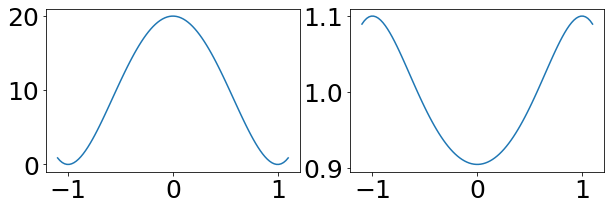

In [75]:
## It would be good to look at some plots 
s=20
m1=1.
M1=1/1.1
c=0.01

def U(x):
    return (x*x-1)*(x*x-1)*s

def getg( x):
    xc=x-1
    xa=x+1
    f=abs(c*s*xa*xa*xc*xc)
    f2=f*f
    xi=np.sqrt(1+m1*f2)
    den=M1*xi+f
    g=xi/den
    return(g)


def getgprime(x):
    xc=x-1
    xa=x+1
    f=abs(c*s*xa*xa*xc*xc)
    f2=f*f
    fp=c*4*s*(x*x-1)*x
    xi=np.sqrt(1+m1*f2)
    gp=-xi*xi*fp/(pow(xi,3)*pow(M1*xi+f,2));
    return(gp)


xvals=np.linspace(-1.1,1.1,100)
fig, (ax1,ax2)= plt.subplots(1, 2,figsize=(10,3))# plt.figure(figsize=(4,4))

ax1.plot(xvals,U(xvals),label="potential")
ax2.plot(xvals,getg(xvals),label="adaptive function")
# ax2.plot(xvals,getgprime(xvals),label="adaptive function")


In [76]:
## When no access to the true moment
# ###########################################
# ## Range of integration + path to save figure
#############################################
range_int=[-10,10]
a=range_int[0]
b=range_int[1]
norm=np.round(integrate.quad(lambda q: np.exp(-U(q)/tau), a,b)[0],16)
true_mom_1 = np.round(integrate.quad(lambda q: np.exp(-U(q)/tau)*(q), a,b)[0],16)/norm
true_mom_2 = np.round(integrate.quad(lambda q: np.exp(-U(q)/tau)*q*q, a,b)[0],16)/norm
true_mom_3 = np.round(integrate.quad(lambda q: np.exp(-U(q)/tau)*(q)**3, a,b)[0],16)/norm
true_mom_4 = np.round(integrate.quad(lambda q: np.exp(-U(q)/tau)*q*q*q*q, a,b)[0],16)/norm

print(true_mom_1)
print(true_mom_2)
print(true_mom_3)
print(true_mom_4)

0.0
0.998745264884567
0.0
0.9999952648845672


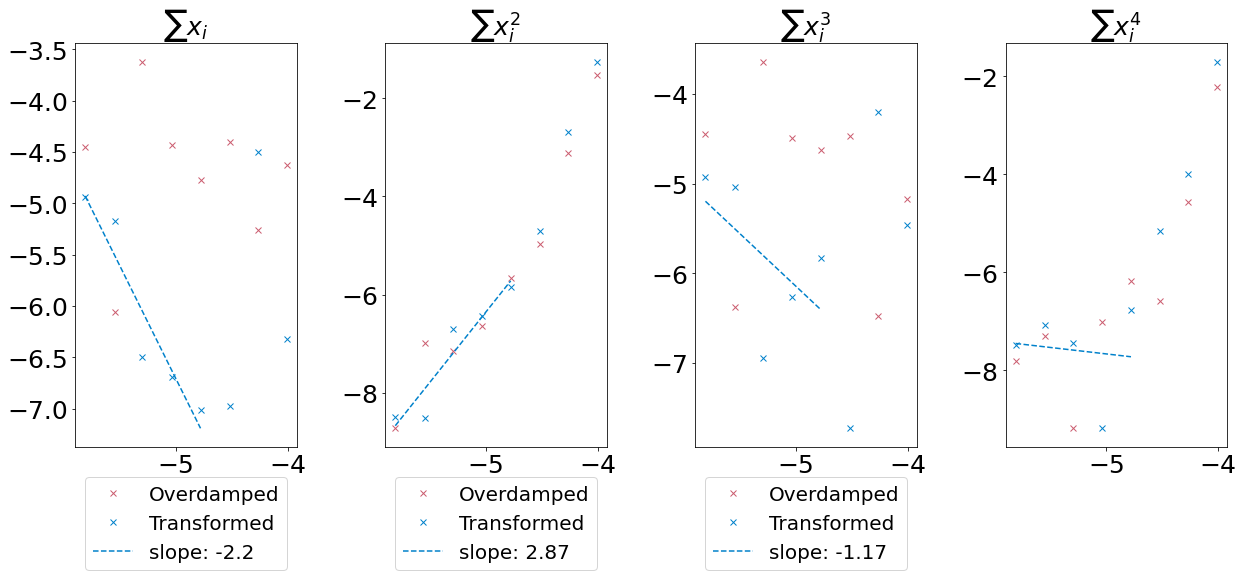

In [77]:
# from settings_and_potential_eddie import *

# ###########################################
# ## Set up the path
# ###########################################
# os.chdir("/home/s2133976/OneDrive/ExtendedProject/Code/Stepupyourgame/Stepupyourgame/data/eddie")
path="/home/s2133976/OneDrive/ExtendedProject/Code/Stepupyourgame/Stepupyourgame/data/C/data_overdamped";


# ###########################################
# ## Interpolate the slope
# ###########################################
xm= np.log(dtlist)
lb=0
ub=-5
x = np.log(dtlist[lb:ub])
A = np.vstack([x, np.ones(len(x))]).T

# ###########################################
# ## Compute the log moments
# ###########################################
fig, (ax1,ax2,ax3,ax4)= plt.subplots(1,4,figsize=(20,7))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

ax1.set_title("$\\sum x_i$",fontsize=font_size)
ax2.set_title("$\\sum x_i^2$",fontsize=font_size)
ax3.set_title("$\\sum x_i^3$",fontsize=font_size)
ax4.set_title("$\\sum x_i^4$",fontsize=font_size)

## no adaptive 
###############
lab="Overdamped"

# Upload moments
mom1_list=np.hstack(openCfile(path+"/noada_moment1.txt"))
mom2_list=np.hstack(openCfile(path+"/noada_moment2.txt"))
mom3_list=np.hstack(openCfile(path+"/noada_moment3.txt"))
mom4_list=np.hstack(openCfile(path+"/noada_moment4.txt"))

mom1_list=np.abs(mom1_list-true_mom_1)
mom2_list=np.abs(mom2_list-true_mom_2)
mom3_list=np.abs(mom3_list-true_mom_3)
mom4_list=np.abs(mom4_list-true_mom_4)


#Plot moments
ax1.plot(xm,np.log(mom1_list),"x",color=myred,label=lab)
ax2.plot(xm,np.log(mom2_list),"x",color=myred,label=lab)
ax3.plot(xm,np.log(mom3_list),"x",color=myred,label=lab)
ax4.plot(xm,np.log(mom4_list),"x",color=myred,label=lab)


## Transformed 
###############
lab="Transformed"

# Upload moments
mom1_list=np.hstack(openCfile(path+"/tr_moment1.txt"))
mom2_list=np.hstack(openCfile(path+"/tr_moment2.txt"))
mom3_list=np.hstack(openCfile(path+"/tr_moment3.txt"))
mom4_list=np.hstack(openCfile(path+"/tr_moment4.txt"))

mom1_list=np.abs(mom1_list-true_mom_1)
mom2_list=np.abs(mom2_list-true_mom_2)
mom3_list=np.abs(mom3_list-true_mom_3)
mom4_list=np.abs(mom4_list-true_mom_4)

ax1.plot(xm,np.log(mom1_list),"x",color=myblue,label=lab)
ax2.plot(xm,np.log(mom2_list),"x",color=myblue,label=lab)
ax3.plot(xm,np.log(mom3_list),"x",color=myblue,label=lab)
ax4.plot(xm,np.log(mom4_list),"x",color=myblue,label=lab)


## interpolation linear  
#first moment
m, c = np.linalg.lstsq(A, np.log(mom1_list)[lb:ub], rcond=None)[0]
ax1.plot(x, m*x + c,"--",label="slope: "+str(round(m,2)),color=myblue)
#second moment
m, c = np.linalg.lstsq(A, np.log(mom2_list)[lb:ub], rcond=None)[0]
ax2.plot(x, m*x + c,"--",label="slope: "+str(round(m,2)),color=myblue)
#third moment
m, c = np.linalg.lstsq(A, np.log(mom3_list)[lb:ub], rcond=None)[0]
ax3.plot(x, m*x + c,"--",label="slope: "+str(round(m,2)),color=myblue)
# #fourth moment
m, c = np.linalg.lstsq(A, np.log(mom4_list)[lb:ub], rcond=None)[0]
ax4.plot(x, m*x + c,"--",label="slope: "+str(round(m,2)),color=myblue)


ax1.legend(fontsize=font_size*0.8,ncol=1,loc="upper center", bbox_to_anchor=(0.5, -0.05))
ax2.legend(fontsize=font_size*0.8,ncol=1,loc="upper center", bbox_to_anchor=(0.5, -0.05))
ax3.legend(fontsize=font_size*0.8,ncol=1,loc="upper center", bbox_to_anchor=(0.5, -0.05))
# ax4.legend(fontsize=font_size*0.8,ncol=1,loc="upper center",bbox_to_anchor=(0.5, -0.05))

# os.chdir("/home/s2133976/OneDrive/ExtendedProject/Code/Stepupyourgame/Stepupyourgame/eddie/visualisations")

# fig.savefig("figures/moments_logplot_overdamped_2d.eps")




## Values taken by g

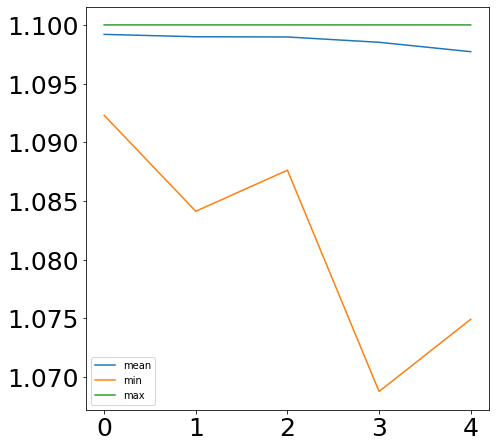

In [78]:
path="/home/s2133976/OneDrive/ExtendedProject/Code/Stepupyourgame/Stepupyourgame/data/C/data_overdamped";
i=0

mom1_list=np.hstack(openCfile(path+"/vec_gi="+str(i)+".txt"))

mom1_list


# ###########################################
# ## Compute the log moments
# ###########################################
fig, (axs)= plt.subplots(1,1,figsize=(7,7))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

# ax.set_title("Distribution of values of g",fontsize=font_size)
# ax2.set_title("Second moment",fontsize=font_size)
# ax3.set_title("Third moment",fontsize=font_size)
# ax4.set_title("Fourth moment",fontsize=font_size)

## no adaptive 
###############
lab="Overdamped"
g_all=[]
j=0
mean_g=[]
min_g=[]
max_g=[]
for i in range(int(len(dtlist)/2)):
    g_vals_i=np.hstack(openCfile(path+"/vec_gi="+str(i)+".txt"))
    mean_g.append(np.mean(g_vals_i))
    min_g.append(np.min(g_vals_i))
    max_g.append(np.max(g_vals_i))
    # print("\n i")
    # print(i)
    # print("Mean g")
    # print(np.mean(g_vals_i))
    # print("min g")
    # print(np.min(g_vals_i))

plt.plot(mean_g,label="mean")
plt.plot(min_g,label="min")
plt.plot(max_g,label="max")
plt.legend()


# Anisotropic 2D
The potential in 2d is 
$$
V(x,y)=s c (x^2+y^2-1)^2
$$


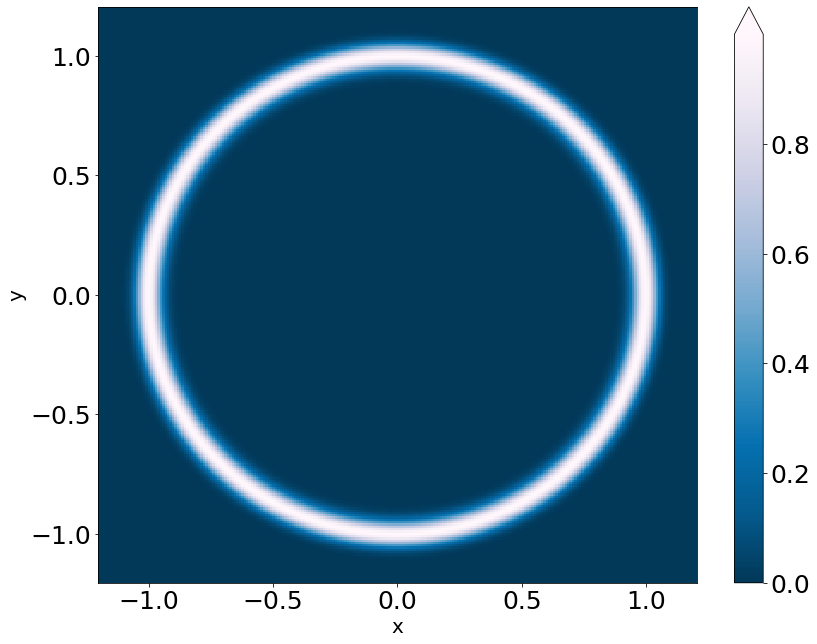

In [2]:
####################
##
#####################
tau=0.1
s=10
fig, (axs)= plt.subplots(1, 1,figsize=(13,10))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
####################
## True distribution
#####################
beta=1/0.1
nbins=250
bound=1.2
X = np.linspace(-bound,bound,nbins)
Y = np.linspace(-bound,bound,nbins)
X, Y = np.meshgrid(X, Y)
Z = np.exp(-beta*s*(X**2 + Y**2-1)**2)
# fig = plt.figure(figsize=(20, 6))
# axs.set_title('True distribution',fontsize=font_size,y=1.1)
axs.pcolormesh(X, Y, Z, norm=colors.LogNorm(vmin=np.min(Z), vmax=1))
pcm = axs.pcolor(X, Y, Z, cmap='PuBu_r', shading='auto')
fig.colorbar(pcm, ax=axs, extend='max')
axs.set_ylabel("y",fontsize=font_size*0.8)
axs.set_xlabel("x",fontsize=font_size*0.8)
os.chdir("/home/s2133976/OneDrive/ExtendedProject/Code/Stepupyourgame/Stepupyourgame/C++/overdamped/visualisation")

fig.savefig("figures/anisotropic_2d_plot.eps")

So we can now try to design a function that could be the basis to create an adaptive function. This function needs to be equally adaptive for $x$ and $y$, a choice could be: 
$$
f(x,y) = sc(x^2+y^2-1)^2 (x^2+y^2)
$$
which looks like :

Text(0.5, 0, 'x')

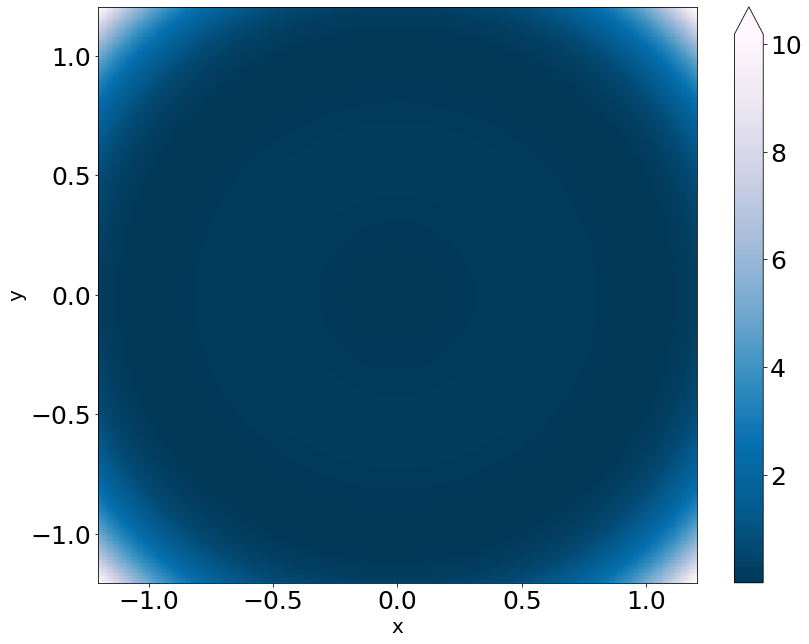

In [3]:
####################
##
#####################
tau=0.1
s=1
fig, (axs)= plt.subplots(1, 1,figsize=(13,10))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
####################
## True distribution
#####################
beta=1/0.1
nbins=250
bound=1.2
X = np.linspace(-bound,bound,nbins)
Y = np.linspace(-bound,bound,nbins)
X, Y = np.meshgrid(X, Y)
Z = np.abs(s*((X**2 + Y**2-1)**2)*(X**2+Y**2))
# fig = plt.figure(figsize=(20, 6))
# axs.set_title('True distribution',fontsize=font_size,y=1.1)
axs.pcolormesh(X, Y, Z,norm=colors.LogNorm(vmin=np.min(Z), vmax=np.max(Z)))
pcm = axs.pcolor(X, Y, Z, cmap='PuBu_r', shading='auto')
fig.colorbar(pcm, ax=axs, extend='max')
axs.set_ylabel("y",fontsize=font_size*0.8)
axs.set_xlabel("x",fontsize=font_size*0.8)

or a cut through y=0

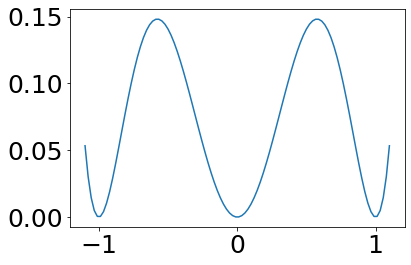

In [4]:
s=np.linspace(-1.1,1.1,100)
def getf(x,y):
    return ((x**2+y**2-1)**2)*(x**2+y**2)

plt.plot(s,getf(s,0))

So we have 
$$
\partial_x f(x,y)=2x (x^2+y^2-1)(3x^2+3y^2-1)
$$

$$
\partial_y f(x,y)=2x (x^2+y^2-1)(3x^2+3y^2-1)
$$

### Adaptive function 

To design an adaptive function, we use a design of $g(x)$ such as: 
using 
$$
g(x,y)=\frac{\sqrt{1+m_1f^2(x,y)}}{M_1 \sqrt{(1+m_1 f(x,y)^2)}+\sqrt{f^2(x,y)}}
$$
with $M_1=1/M$ is the multiplicative upper bound (so if $M=1.5$ then the step size is 1.5 times larger, and if $m_1=m^2$, and m is the multiplicative lower bound) 

and the partial derivative is
$$
\partial_x g(x,y)=- \text{sign} f(x,y) \frac{\partial_x f(x,y)}{\sqrt{m_1 f(x,y)^2+1}\left(M_1 \sqrt{m_1 f(x,y)^2+1} +\sqrt{f(x,y)^2}\right)^2}
$$
and 
$$
\partial_y g(x,y)=- \text{sign} f(x,y) \frac{\partial_yf(x,y)}{\sqrt{m_1 f(x,y)^2+1}\left(M_1 \sqrt{m_1 f(x,y)^2+1} +\sqrt{f(x,y)^2}\right)^2}
$$


We choose 
\begin{equation}
f(x,y) = (x^2+y^2-1)^2(x^2+y^2) c s 
\end{equation}

such that 
\begin{align}
\partial_x f(x,y) = 2x(x^2+y^2-1)(3x^2+3y^2-1) c s
\end{align}
and 
\begin{align}
\partial_y f(x,y) = 2y(x^2+y^2-1)(3x^2+3y^2-1) c s
\end{align}

We could choose as well: 

\begin{equation}
f(x,y) = (x^2+y^2-1)(x^2+y^2) c s 
\end{equation}

such that 
\begin{align}
\partial_x f(x,y) = 2x(x^2+y^2-1) c s
\end{align}
and 
\begin{align}
\partial_y f(x,y) = 2y(x^2+y^2-1) c s
\end{align}


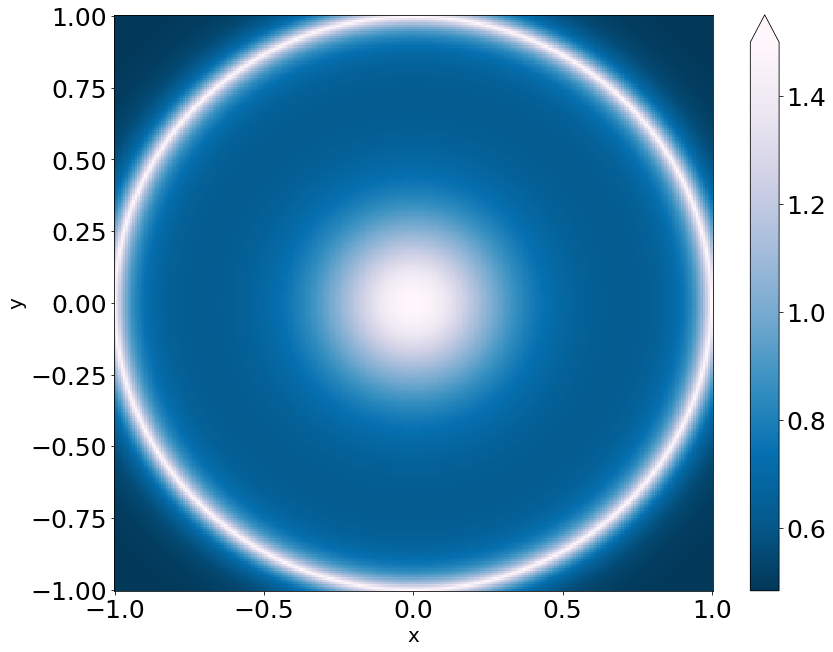

In [41]:
####################
##
#####################
tau=0.1
s=10
c=0.5
m1=0.5         
M1=1/1.5  

fig, (axs)= plt.subplots(1, 1,figsize=(13,10))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
####################
## True distribution
#####################
beta=1/0.1
nbins=250
bound=1.
X = np.linspace(-bound,bound,nbins)
Y = np.linspace(-bound,bound,nbins)
X, Y = np.meshgrid(X, Y)
F = (c*s*(X**2 + Y**2-1)*(X**2+Y**2))
F2=F*F
Xi=np.sqrt(1+m1*F2)
G=(Xi/(M1*Xi+np.sqrt(F2)))

# fig = plt.figure(figsize=(20, 6))
# axs.set_title('True distribution',fontsize=font_size,y=1.1)
axs.pcolormesh(X, Y, G, norm=colors.LogNorm(vmin=np.min(G), vmax=np.max(G)))
pcm = axs.pcolor(X, Y, G, cmap='PuBu_r', shading='auto')
fig.colorbar(pcm, ax=axs, extend='max')
axs.set_ylabel("y",fontsize=font_size*0.8)
axs.set_xlabel("x",fontsize=font_size*0.8)
os.chdir("/home/s2133976/OneDrive/ExtendedProject/Code/Stepupyourgame/Stepupyourgame/C++/overdamped/visualisation")

# fig.savefig("figures/anisotropic_2d_gfunc.eps")

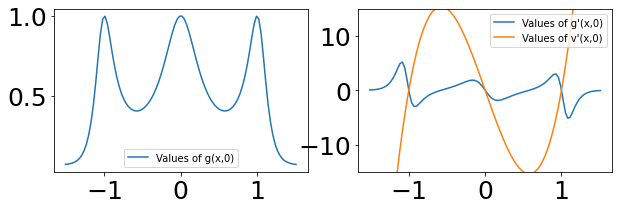

In [49]:
m1=0.005
M1=1/1.
s=10
c=1
def vp(x,y):
    return 4*x*s*(x*x+y*y-1)

def getg(x, y):
    f=abs((c*s*(x*x+y*y-1)**2)*(x*x+y*y));
    f2=f*f
    xi=np.sqrt(1+m1*f2)
    den=M1*xi+(f)
    g=xi/den
    return(g)

def getgprime_x(x,y):
    f=(c*s*(x*x+y*y-1)**2*(x*x+y*y))
    f2=f*f
    fp=c*s*2*(x*x+y*y-1)*(3*x*x+3*y*y-1)*x
    xi=np.sqrt(1+m1*f2)
    gp=-np.sign(f)*fp/(xi*pow(M1*xi+np.abs(f),2))
    return(gp)

def getgprime_y(x,y):
    f=(c*s*(x*x+y*y-1)**2*(x*x+y*y))
    f2=f*f
    fp=c*s*2*(x*x+y*y-1)*(3*x*x+3*y*y-1)*y
    xi=np.sqrt(1+m1*f2)
    gp=-np.sign(f)*fp/(xi*pow(M1*xi+np.abs(f),2))
    return(gp)

fig, (ax1,ax2)= plt.subplots(1, 2,figsize=(10,3))# plt.figure(figsize=(4,4))

xvals=np.linspace(-1.51,1.51,100)
y0=np.zeros(len(xvals))
def getf(x,y):
    return c*s*2*(x*x+y*y-1)*(3*x*x+3*y*y-1)*y
def fp(x):
    return  c*s*2*x*(x*x-1)*(3*x*x-1)

# 
ax1.plot(xvals,getg(xvals,0),label="Values of g(x,0)")
ax2.plot(xvals,getgprime_x(xvals,0),label="Values of g'(x,0)")
ax2.plot(xvals,vp(xvals,0),label="Values of v'(x,0)")
ax2.set_ylim(-15,15)

ax1.legend()
ax2.legend()

## Choice 2 of adaptive function 

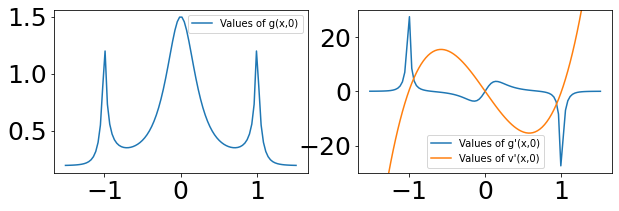

In [48]:
m1=0.05
M1=1/1.5
s=10
c=1
def vp(x,y):
    return 4*x*s*(x*x+y*y-1)

def getg(x, y):
    f=abs((c*s*(x*x+y*y-1))*(x*x+y*y));
    f2=f*f
    xi=np.sqrt(1+m1*f2)
    den=M1*xi+(f)
    g=xi/den
    return(g)

def getgprime_x(x,y):
    f=abs((c*s*(x*x+y*y-1))*(x*x+y*y));
    f2=f*f
    fp=c*s*2*x*(2*x*x+2*y*y-1)
    xi=np.sqrt(1+m1*f2)
    gp=-np.sign(f)*fp/(xi*pow(M1*xi+np.abs(f),2))
    return(gp)

def getgprime_y(x,y):
    f=abs((c*s*(x*x+y*y-1)*(x*x+y*y)));
    f2=f*f
    fp=c*s*2*y*(2*x*x+2*y*y-1)
    xi=np.sqrt(1+m1*f2)
    gp=-np.sign(f)*fp/(xi*pow(M1*xi+np.abs(f),2))
    return(gp)

fig, (ax1,ax2)= plt.subplots(1, 2,figsize=(10,3))# plt.figure(figsize=(4,4))

xvals=np.linspace(-1.51,1.51,100)
y0=np.zeros(len(xvals))
def getf(x,y):
    return c*s*2*(x*x+y*y-1)*(3*x*x+3*y*y-1)*y
def fp(x):
    return  c*s*2*x*(x*x-1)*(3*x*x-1)

# 
ax1.plot(xvals,getg(xvals,0),label="Values of g(x,0)")
ax2.plot(xvals,getgprime_x(xvals,0),label="Values of g'(x,0)")
ax2.plot(xvals,vp(xvals,0),label="Values of v'(x,0)")
ax2.set_ylim(-30,30)

ax1.legend()
ax2.legend()

## Compute moments 
$$
 \int_\Omega \exp(-\beta (x^2+y^2-1)^2) x dx =0\\
\int_\Omega \exp(-\beta (x^2+y^2-1)^2) y dy =0\\
\int_\Omega  \exp(-\beta (x^2+y^2-1)^2) U(x,y) dx dy=0.049 \dots
$$

In [53]:
## When no access to the true moment
# ###########################################
# ## Range of integration + path to save figure
#############################################
range_int=[-15,15]
a=range_int[0]
b=range_int[1]
# norm=np.round(integrate.quad(lambda q: np.exp(-U(q)/tau), a,b)[0],16)
# true_mom_1 = np.round(integrate.quad(lambda q: np.exp(-U/tau)*U, a,b)[0],16)/norm
# true_mom_2 = np.round(integrate.quad(lambda q: np.exp(-U(q)/tau)*q*q, a,b)[0],16)/norm
# true_mom_3 = np.round(integrate.quad(lambda q: np.exp(-U(q)/tau)*(q)**3, a,b)[0],16)/norm
# true_mom_4 = np.round(integrate.quad(lambda q: np.exp(-U(q)/tau)*q*q*q*q, a,b)[0],16)/norm
s=15
def U(x,y):
    res=s*(x*x+y*y-1)*(x*x+y*y-1)
    return res

def target(x,y):
    return np.exp(-U(x,y)/tau)

def mom_3(x,y):
   return np.exp(-U(x,y)/tau)*U(x,y)
normalising_cst=integrate.dblquad(target,a,b,a,b)[0]
print(normalising_cst)
true_mom_3=integrate.dblquad(mom_3,a,b,a,b)[0]/normalising_cst
print(true_mom_3)

/home/s2133976/.local/lib/python3.8/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


0.4390877279589831
0.05041158188085211


In [54]:
true_mom_1=0
true_mom_2=0 #

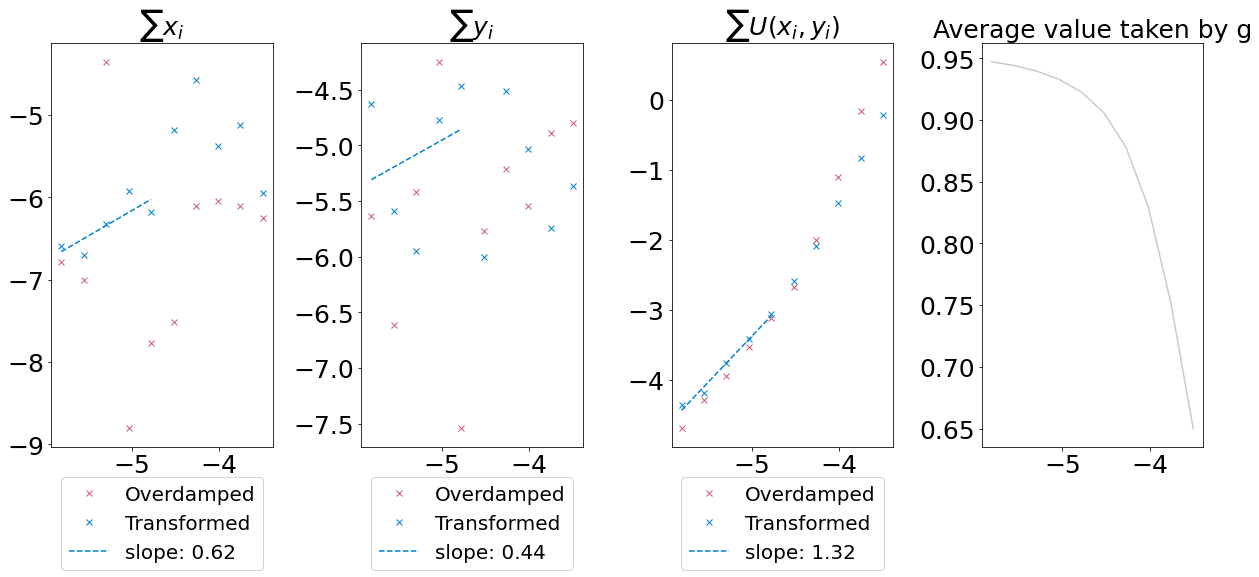

In [55]:
# from settings_and_potential_eddie import *

# ###########################################
# ## Set up the path
# ###########################################
# os.chdir("/home/s2133976/OneDrive/ExtendedProject/Code/Stepupyourgame/Stepupyourgame/data/eddie")
path="/home/s2133976/OneDrive/ExtendedProject/Code/Stepupyourgame/Stepupyourgame/C++/overdamped/"


# ###########################################
# ## Interpolate the slope
# ###########################################
xm= np.log(dtlist)
lb=0
ub=-5
x = np.log(dtlist[lb:ub])
A = np.vstack([x, np.ones(len(x))]).T

# ###########################################
# ## Compute the log moments
# ###########################################
fig, (ax1,ax2,ax3,ax4)= plt.subplots(1,4,figsize=(20,7))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

ax1.set_title("$\\sum x_i$",fontsize=font_size)
ax2.set_title("$\\sum y_i$",fontsize=font_size)
ax3.set_title("$\\sum U(x_i,y_i)$",fontsize=font_size)
ax4.set_title("Average value taken by g",fontsize=font_size)

## no adaptive 
###############
lab="Overdamped"

# Upload moments
mom1_list=np.hstack(openCfile(path+"overdamped_2d/noada_moment1.txt"))
mom2_list=np.hstack(openCfile(path+"overdamped_2d/noada_moment2.txt"))
mom3_list=np.hstack(openCfile(path+"overdamped_2d/noada_moment3.txt"))
# mom4_list=np.hstack(openCfile("overdamped_2d/noada_moment4.txt"))

mom1_list=np.abs(mom1_list-true_mom_1)
mom2_list=np.abs(mom2_list-true_mom_2)
mom3_list=np.abs(mom3_list-true_mom_3)
# mom4_list=np.abs(mom4_list-true_mom_4)


#Plot moments
ax1.plot(xm,np.log(mom1_list),"x",color=myred,label=lab)
ax2.plot(xm,np.log(mom2_list),"x",color=myred,label=lab)
ax3.plot(xm,np.log(mom3_list),"x",color=myred,label=lab)
# ax4.plot(xm,np.log(mom4_list),"x",color=myred,label=lab)


## Transformed 
###############
lab="Transformed"

# Upload moments
mom1_list=np.hstack(openCfile(path+"overdamped_2d/tr_moment1.txt"))
mom2_list=np.hstack(openCfile(path+"overdamped_2d/tr_moment2.txt"))
mom3_list=np.hstack(openCfile(path+"overdamped_2d/tr_moment3.txt"))
g_vals=np.hstack(openCfile(path+"overdamped_2d/tr_moment4.txt"))

mom1_list=np.abs(mom1_list-true_mom_1)
mom2_list=np.abs(mom2_list-true_mom_2)
mom3_list=np.abs(mom3_list-true_mom_3)
# mom4_list=np.abs(mom4_list-true_mom_4)

ax1.plot(xm,np.log(mom1_list),"x",color=myblue,label=lab)
ax2.plot(xm,np.log(mom2_list),"x",color=myblue,label=lab)
ax3.plot(xm,np.log(mom3_list),"x",color=myblue,label=lab)
ax4.plot(xm,g_vals,"-",color=mygrey,label=lab)


## interpolation linear  
#first moment
m, c = np.linalg.lstsq(A, np.log(mom1_list)[lb:ub], rcond=None)[0]
ax1.plot(x, m*x + c,"--",label="slope: "+str(round(m,2)),color=myblue)
#second moment
m, c = np.linalg.lstsq(A, np.log(mom2_list)[lb:ub], rcond=None)[0]
ax2.plot(x, m*x + c,"--",label="slope: "+str(round(m,2)),color=myblue)
#third moment
m, c = np.linalg.lstsq(A, np.log(mom3_list)[lb:ub], rcond=None)[0]
ax3.plot(x, m*x + c,"--",label="slope: "+str(round(m,2)),color=myblue)
# #fourth moment
# m, c = np.linalg.lstsq(A, np.log(mom4_list)[lb:ub], rcond=None)[0]
# ax4.plot(x, m*x + c,"--",label="slope: "+str(round(m,2)),color=myblue)


ax1.legend(fontsize=font_size*0.8,ncol=1,loc="upper center", bbox_to_anchor=(0.5, -0.05))
ax2.legend(fontsize=font_size*0.8,ncol=1,loc="upper center", bbox_to_anchor=(0.5, -0.05))
ax3.legend(fontsize=font_size*0.8,ncol=1,loc="upper center", bbox_to_anchor=(0.5, -0.05))
# ax4.legend(fontsize=font_size*0.8,ncol=1,loc="upper center",bbox_to_anchor=(0.5, -0.05))

# os.chdir("/home/s2133976/OneDrive/ExtendedProject/Code/Stepupyourgame/Stepupyourgame/eddie/visualisations")

# fig.savefig("figures/moments_logplot_overdamped_2d.eps")


